In [1]:
# from https://github.com/H-arshit/UNET-On-COCO/blob/master/tf_Keras_COCO_UNET.ipynb
# Importing Data From COCO

from pycocotools import coco, cocoeval, _mask
from pycocotools import mask as maskUtils 
import array
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import os
import shutil
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
%matplotlib inline

In [ ]:
COCO_DIR = 'coco-2017'
TRAIN_IMG = COCO_DIR + '/train/data'
VAL_IMG = COCO_DIR + '/validation/data'

In [ ]:
CATEGORY_NAMES=['person']

ANNOTATION_FILE_VAL = 'coco-2017/raw/instances_val2017.json'
ANNOTATION_FILE_TRAIN = 'coco-2017/raw/instances_train2017.json'


coco_train = coco.COCO(ANNOTATION_FILE_TRAIN)
catIds_train = coco_train.getCatIds(catNms=CATEGORY_NAMES);
imgIds_train = coco_train.getImgIds(catIds=catIds_train);
imgDict_train = coco_train.loadImgs(imgIds_train)
len(imgIds_train) , len(catIds_train)


coco_val = coco.COCO(ANNOTATION_FILE_VAL)
catIds_val = coco_val.getCatIds(catNms=CATEGORY_NAMES);
imgIds_val = coco_val.getImgIds(catIds=catIds_val);
imgDict_val = coco_val.loadImgs(imgIds_val)
len(imgIds_val) , len(catIds_val)

In [ ]:
from random import shuffle

shuffle(imgIds_train)
shuffle(imgIds_val)

imgIds_train = imgIds_train[0:6000]
imgIds_val = imgIds_val[0:600]

In [ ]:
!mkdir train_small

In [ ]:
train_images_person = ["{0:012d}.jpg".format(ids) for ids in imgIds_train]
# del_img_train = set(os.listdir("coco-2017/train/data")) - set(train_images_person)
for file_name in train_images_person:
    src = TRAIN_IMG + "/" + file_name
    file_path = "train_small/" + file_name
    if not os.path.exists(file_path):
        shutil.copy(src, file_path)

In [ ]:
print(len(os.listdir("train_small")))

In [ ]:
!mkdir val_small

In [ ]:
val_images_person = ["{0:012d}.jpg".format(ids) for ids in imgIds_val]
# del_img_val = set(os.listdir(VAL_IMG)) - set(val_images_person)
i = 1
for file_name in val_images_person:
    src = VAL_IMG + "/" + file_name
    file_path = "val_small/" + file_name
    if not os.path.exists(file_path):
        print(i)
        shutil.copy(src, file_path)
        i+=1

len(os.listdir("val_small"))

In [ ]:
from PIL import Image

In [ ]:
!mkdir mask_train_2017

In [ ]:
count = 0 

for ID in imgIds_train:

    file_path = "./mask_train_2017/COCO_train2017_{0:012d}.jpg".format(ID)
  
    sampleImgIds = coco_train.getImgIds(imgIds = [ID])
    sampleImgDict = coco_train.loadImgs(sampleImgIds[np.random.randint(0,len(sampleImgIds))])[0]

    annIds = coco_train.getAnnIds(imgIds=sampleImgDict['id'], catIds=catIds_train, iscrowd=0)
    anns = coco_train.loadAnns(annIds)


    mask = coco_train.annToMask(anns[0])
    for i in range(len(anns)):
        mask = mask | coco_train.annToMask(anns[i])
  
    mask = Image.fromarray(mask * 255 , mode = "L")
    mask.save(file_path)
    count = count + 1
    print(count)

In [ ]:
!mkdir mask_val_2017

In [ ]:
count = 0 
for ID in imgIds_val:

    file_path = "./mask_val_2017/COCO_val2017_{0:012d}.jpg".format(ID)
  
    sampleImgIds = coco_val.getImgIds(imgIds = [ID])
    sampleImgDict = coco_val.loadImgs(sampleImgIds[np.random.randint(0,len(sampleImgIds))])[0]

    annIds = coco_val.getAnnIds(imgIds=sampleImgDict['id'], catIds=catIds_val, iscrowd=0)
    anns = coco_val.loadAnns(annIds)


    mask = coco_val.annToMask(anns[0])
    for i in range(len(anns)):
        mask = mask | coco_val.annToMask(anns[i])
  
    mask = Image.fromarray(mask * 255 , mode = "L")
    mask.save(file_path)
  
    count = count + 1
    print(count)

# Data Generator

In [2]:
import os
import sys
import random

import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *


seed = 0

random.seed = seed
np.random.seed = seed 

2022-06-10 07:38:03.082309: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mmkeskar/.local/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/nvidia/lib64:/usr/local/cuda/lib64
2022-06-10 07:38:03.082379: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
class DataGen(tf.keras.utils.Sequence):
  
    def __init__(self , path_input , path_mask , batch_size = 8 , image_size = 128 , split='train'):
    
        self.ids = os.listdir(path_input)
        self.path_input = path_input
        self.path_mask = path_mask
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        self.split = split
  
    def __load__(self , id_name):
    
        image_path = os.path.join(self.path_input , id_name)
        mask_path = os.path.join(self.path_mask , "COCO_{}2017_{}".format(self.split, id_name)) 
    
        image = cv2.imread(image_path , 1) # 1 specifies RGB format
        image = cv2.resize(image , (self.image_size , self.image_size)) # resizing before inserting to the network
    
        mask = cv2.imread(mask_path)
        mask = cv2.resize(mask , (self.image_size , self.image_size))
        mask = mask[:, :, 0].reshape((self.image_size , self.image_size , 1))
      
        #normalize image
        image = image / 255.0
        mask = mask / 255.0
    
        return image , mask
  
    def __getitem__(self , index):
    
        if (index + 1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index * self.batch_size
        
        file_batch = self.ids[index * self.batch_size : (index + 1) * self.batch_size]
    
        images = []
        masks = []
    
        for id_name in file_batch : 
      
            _img , _mask = self.__load__(id_name)
            images.append(_img)
            masks.append(_mask)
    
    
        images = np.array(images)
        masks = np.array(masks)
    
    
        return images , masks
  
  
    def on_epoch_end(self):
        pass
  
  
    def __len__(self):
    
        return int(np.ceil(len(self.ids) / float(self.batch_size)))

# UNet

In [3]:
def down_block(
    input_tensor,
    no_filters,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    kernel_initializer="he_normal",
    max_pool_window=(2, 2),
    max_pool_stride=(2, 2)
):
    conv = Conv2D(
        filters=no_filters,
        kernel_size=kernel_size,
        strides=strides,
        activation=None,
        padding=padding,
        kernel_initializer=kernel_initializer
    )(input_tensor)

    conv = BatchNormalization(scale=True)(conv)

    conv = Activation("relu")(conv)

    conv = Conv2D(
        filters=no_filters,
        kernel_size=kernel_size,
        strides=strides,
        activation=None,
        padding=padding,
        kernel_initializer=kernel_initializer
    )(conv)

    conv = BatchNormalization(scale=True)(conv)

    # conv for skip connection
    conv = Activation("relu")(conv)

    pool = MaxPooling2D(pool_size=max_pool_window, strides=max_pool_stride)(conv)

    return conv, pool

In [4]:
def bottle_neck(
    input_tensor,
    no_filters,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    kernel_initializer="he_normal"
):
    conv = Conv2D(
        filters=no_filters,
        kernel_size=kernel_size,
        strides=strides,
        activation=None,
        padding=padding,
        kernel_initializer=kernel_initializer
    )(input_tensor)

    conv = BatchNormalization(scale=True)(conv)

    conv = Activation("relu")(conv)

    conv = Conv2D(
        filters=no_filters,
        kernel_size=kernel_size,
        strides=strides,
        activation=None,
        padding=padding,
        kernel_initializer=kernel_initializer
    )(conv)

    conv = BatchNormalization(scale=True)(conv)

    conv = Activation("relu")(conv)

    return conv

In [5]:
def up_block(    
    input_tensor,
    no_filters,
    skip_connection, 
    kernel_size=(3, 3),
    strides=(1, 1),
    upsampling_factor = (2,2),
    max_pool_window = (2,2),
    padding="same",
    kernel_initializer="he_normal"):
    
    
    conv = Conv2D(
        filters = no_filters,
        kernel_size= max_pool_window,
        strides = strides,
        activation = None,
        padding = padding,
        kernel_initializer=kernel_initializer
    )(UpSampling2D(size = upsampling_factor)(input_tensor))
    
    conv = BatchNormalization(scale=True)(conv)

    conv = Activation("relu")(conv) 
    
    
    conv = concatenate( [skip_connection , conv]  , axis = -1)
    
    
    conv = Conv2D(
        filters=no_filters,
        kernel_size=kernel_size,
        strides=strides,
        activation=None,
        padding=padding,
        kernel_initializer=kernel_initializer
    )(conv)

    conv = BatchNormalization(scale=True)(conv)

    conv = Activation("relu")(conv)

    conv = Conv2D(
        filters=no_filters,
        kernel_size=kernel_size,
        strides=strides,
        activation=None,
        padding=padding,
        kernel_initializer=kernel_initializer
    )(conv)

    conv = BatchNormalization(scale=True)(conv)

    conv = Activation("relu")(conv)
    
    return conv

In [6]:
def output_block(input_tensor,
    padding="same",
    kernel_initializer="he_normal"
):
    
    conv = Conv2D(
        filters=2,
        kernel_size=(3,3),
        strides=(1,1),
        activation="relu",
        padding=padding,
        kernel_initializer=kernel_initializer
    )(input_tensor)
    
    
    conv = Conv2D(
        filters=1,
        kernel_size=(1,1),
        strides=(1,1),
        activation="relu",
        padding=padding,
        kernel_initializer=kernel_initializer
    )(conv)
    
    conv = Conv2D(
        filters=1,
        kernel_size=(1,1),
        strides=(1,1),
        activation="sigmoid",
        padding=padding,
        kernel_initializer=kernel_initializer
    )(conv)
    
    
    return conv

In [7]:
def UNet(input_shape = (128,128,3)):
    
    filter_size = [32,64,128,256,512]
    
    inputs = Input(shape = input_shape)
    
    d1 , p1 = down_block(input_tensor= inputs,
                         no_filters=filter_size[0],
                         kernel_size = (3,3),
                         strides=(1,1),
                         padding="same",
                         kernel_initializer="he_normal",
                         max_pool_window=(2,2),
                         max_pool_stride=(2,2))
    
    
    d2 , p2 = down_block(input_tensor= p1,
                         no_filters=filter_size[1],
                         kernel_size = (3,3),
                         strides=(1,1),
                         padding="same",
                         kernel_initializer="he_normal",
                         max_pool_window=(2,2),
                         max_pool_stride=(2,2))
    
    
    
    d3 , p3 = down_block(input_tensor= p2,
                         no_filters=filter_size[2],
                         kernel_size = (3,3),
                         strides=(1,1),
                         padding="same",
                         kernel_initializer="he_normal",
                         max_pool_window=(2,2),
                         max_pool_stride=(2,2))
    
    
    
    d4 , p4 = down_block(input_tensor= p3,
                         no_filters=filter_size[3],
                         kernel_size = (3,3),
                         strides=(1,1),
                         padding="same",
                         kernel_initializer="he_normal",
                         max_pool_window=(2,2),
                         max_pool_stride=(2,2))
    
    
    b = bottle_neck(input_tensor= p4,
                         no_filters=filter_size[4],
                         kernel_size = (3,3),
                         strides=(1,1),
                         padding="same",
                         kernel_initializer="he_normal")
    
    
    
    u4 = up_block(input_tensor = b,
                  no_filters = filter_size[3],
                  skip_connection = d4,
                  kernel_size=(3, 3),
                  strides=(1, 1),
                  upsampling_factor = (2,2),
                  max_pool_window = (2,2),
                  padding="same",
                  kernel_initializer="he_normal")
    
    u3 = up_block(input_tensor = u4,
                  no_filters = filter_size[2],
                  skip_connection = d3,
                  kernel_size=(3, 3),
                  strides=(1, 1),
                  upsampling_factor = (2,2),
                  max_pool_window = (2,2),
                  padding="same",
                  kernel_initializer="he_normal")
    
    
    u2 = up_block(input_tensor = u3,
                  no_filters = filter_size[1],
                  skip_connection = d2,
                  kernel_size=(3, 3),
                  strides=(1, 1),
                  upsampling_factor = (2,2),
                  max_pool_window = (2,2),
                  padding="same",
                  kernel_initializer="he_normal")
    
    
    u1 = up_block(input_tensor = u2,
                  no_filters = filter_size[0],
                  skip_connection = d1,
                  kernel_size=(3, 3),
                  strides=(1, 1),
                  upsampling_factor = (2,2),
                  max_pool_window = (2,2),
                  padding="same",
                  kernel_initializer="he_normal")
    
    
    
    output = output_block(input_tensor=u1 , 
                         padding = "same",
                         kernel_initializer= "he_normal")
    
    model = Model(inputs = inputs , outputs = output)
    
    
    return model

In [8]:
with tf.device('/GPU:0'):
    model = UNet(input_shape = (128,128,3))
    model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

2022-06-09 15:16:19.536285: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mmkeskar/.local/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/nvidia/lib64:/usr/local/cuda/lib64
2022-06-09 15:16:19.536408: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mmkeskar/.local/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/nvidia/lib64:/usr/local/cuda/lib64
2022-06-09 15:16:19.536479: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mmkeskar/.local/lib/python3.9/

In [9]:
image_size = 128 
epochs = 10
batch_size = 32

In [10]:
train_gen = DataGen(path_input = "train_small" , path_mask = './mask_train_2017' , batch_size = batch_size , image_size = image_size)
val_gen = DataGen(path_input =  "val_small", path_mask =  './mask_val_2017', batch_size = batch_size , image_size = image_size, split='val')


train_steps =  len(os.listdir("train_small"))/batch_size


model.fit(train_gen , validation_data = val_gen , steps_per_epoch = train_steps , epochs=epochs)

Epoch 1/10
 72/187 [==========>...................] - ETA: 17:58 - loss: 0.7032 - accuracy: 0.7741

Premature end of JPEG file


187/187 [==============================] - 1350s 7s/step - loss: 0.6962 - accuracy: 0.7997 - val_loss: 0.6871 - val_accuracy: 0.8195
Epoch 2/10
187/187 [==============================] - 838s 4s/step - loss: 0.6841 - accuracy: 0.8172 - val_loss: 0.6811 - val_accuracy: 0.8174
Epoch 3/10
187/187 [==============================] - 822s 4s/step - loss: 0.6776 - accuracy: 0.8274 - val_loss: 0.6750 - val_accuracy: 0.8178
Epoch 4/10
187/187 [==============================] - 852s 5s/step - loss: 0.6721 - accuracy: 0.8185 - val_loss: 0.6692 - val_accuracy: 0.8179
Epoch 5/10
187/187 [==============================] - 830s 4s/step - loss: 0.6664 - accuracy: 0.8185 - val_loss: 0.6636 - val_accuracy: 0.8179
Epoch 6/10
187/187 [==============================] - 976s 5s/step - loss: 0.6602 - accuracy: 0.8238 - val_loss: 0.6579 - val_accuracy: 0.8179
Epoch 7/10
187/187 [==============================] - 1074s 6s/step - loss: 0.6547 - accuracy: 0.8220 - val_loss: 0.6524 - val_accuracy: 0.8179
Epoch 8/

In [11]:
!mkdir saved_models
model.save('saved_models/unet_model_v3.2')

mkdir: cannot create directory ‘saved_models’: File exists


INFO:tensorflow:Assets written to: saved_models/unet_model_v3.2/assets


INFO:tensorflow:Assets written to: saved_models/unet_model_v3.2/assets


1/1 [==============================] - 2s 2s/step


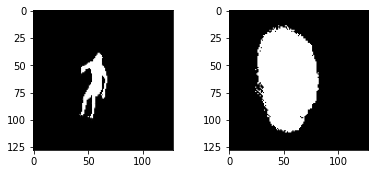

In [14]:
x, y = val_gen.__getitem__(4)
result = model.predict(x)

result = result > 0.5

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [4]:
image_size = 128 
epochs = 10
batch_size = 32
val_gen = DataGen(path_input =  "val_small", path_mask =  './mask_val_2017', batch_size = batch_size , image_size = image_size, split='val')

model = tf.keras.models.load_model('saved_models/unet_model_v3.2')
result = model.evaluate(val_gen)

2022-06-10 07:41:55.922397: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mmkeskar/.local/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/nvidia/lib64:/usr/local/cuda/lib64
2022-06-10 07:41:55.922879: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mmkeskar/.local/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/nvidia/lib64:/usr/local/cuda/lib64
2022-06-10 07:41:55.923230: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mmkeskar/.local/lib/python3.9/

19/19 [==============================] - 46s 2s/step - loss: 0.6772 - accuracy: 0.8004
